In [36]:
import os
import sys
import argparse
import json
from matplotlib.backends.backend_pdf import PdfPages
import wandb
import datetime

def add_to_sys_path(root_dir):
    for dirpath, dirnames, filenames in os.walk(root_dir):
        sys.path.append(dirpath)        
root_dir = '/home/jovyan/pablo_tostado/bird_song/enSongDec/'
add_to_sys_path(root_dir)

import pickle as pkl
import numpy as np
import warnings
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from FFNNmodel import FeedforwardNeuralNetwork, ffnn_train, ffnn_evaluate, ffnn_predict
from neural_audio_dataset import NeuralAudioDataset
import utils.audio_utils as au
import utils.encodec_utils as eu
import utils.signal_utils as su
import utils.train_utils as tu
import utils.visualization_utils as vu

import songbirdcore.spikefinder.spike_analysis_helper as sh
import songbirdcore.spikefinder.filtering_helper as fh

# EncoDec
from encodec import EncodecModel
from encodec.utils import convert_audio

# Tim S. noise reduce
import noisereduce as nr

In [2]:
# Directory path
models_checkpoints_dir = '/home/jovyan/pablo_tostado/bird_song/enSongDec/models_checkpoints/'
model_extension = '.pt'  # Change this to the extension you want

# Filter files based on the extension
model_files = [file for file in os.listdir(models_checkpoints_dir) if file.endswith(model_extension)]

# Print the filtered files
# print(len(filtered_files), filtered_files)

In [3]:
# Load models CSV info file
info_path = os.path.join(models_checkpoints_dir, 'models_info.csv')

# Check if the file exists and 
if os.path.isfile(info_path):
    df_models = pd.read_csv(info_path)

df_models['tot_val_err'] = df_models['tot_val_err'].apply(ast.literal_eval)
df_models['tot_train_err'] = df_models['tot_train_err'].apply(ast.literal_eval)


In [4]:
projects = { 
    '1': ['z_w12m7_20', 'ra', 'RAW'], 
    '2': ['z_r12r13_21', 'ra', 'RAW'],  
    '3': ['z_w12m7_20', 'hvc', 'RAW'], 
    '4': ['z_r12r13_21', 'hvc', 'RAW'], 
    '5': ['z_w12m7_20', 'ra', 'TRAJECTORIES'],
    '6': ['z_r12r13_21', 'ra', 'TRAJECTORIES'],
    '7': ['z_w12m7_20', 'hvc', 'TRAJECTORIES'],  
    '8': ['z_r12r13_21', 'hvc', 'TRAJECTORIES']
}

for k, v in projects.items():
    print(k, v)

1 ['z_w12m7_20', 'ra', 'RAW']
2 ['z_r12r13_21', 'ra', 'RAW']
3 ['z_w12m7_20', 'hvc', 'RAW']
4 ['z_r12r13_21', 'hvc', 'RAW']
5 ['z_w12m7_20', 'ra', 'TRAJECTORIES']
6 ['z_r12r13_21', 'ra', 'TRAJECTORIES']
7 ['z_w12m7_20', 'hvc', 'TRAJECTORIES']
8 ['z_r12r13_21', 'hvc', 'TRAJECTORIES']


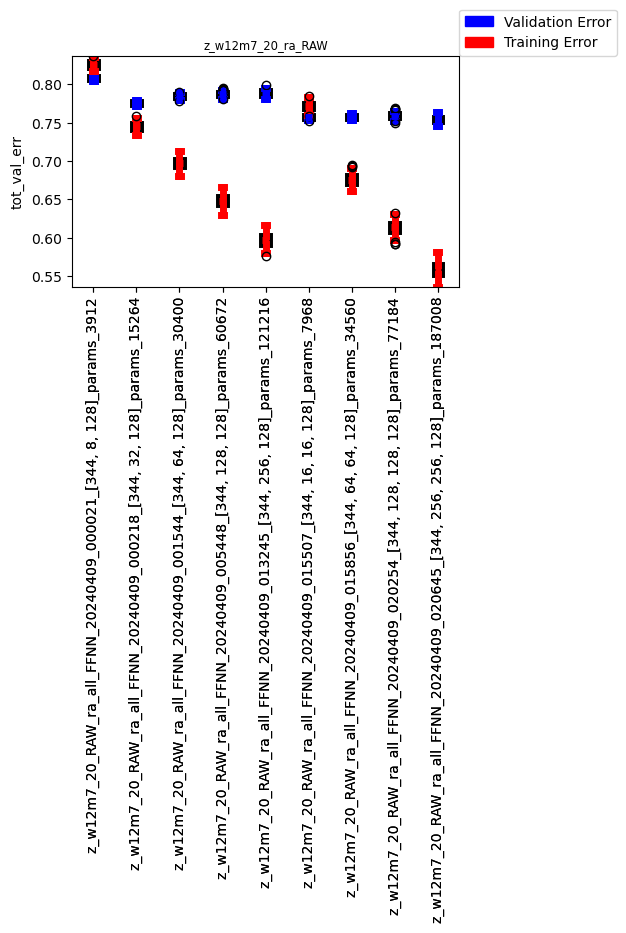

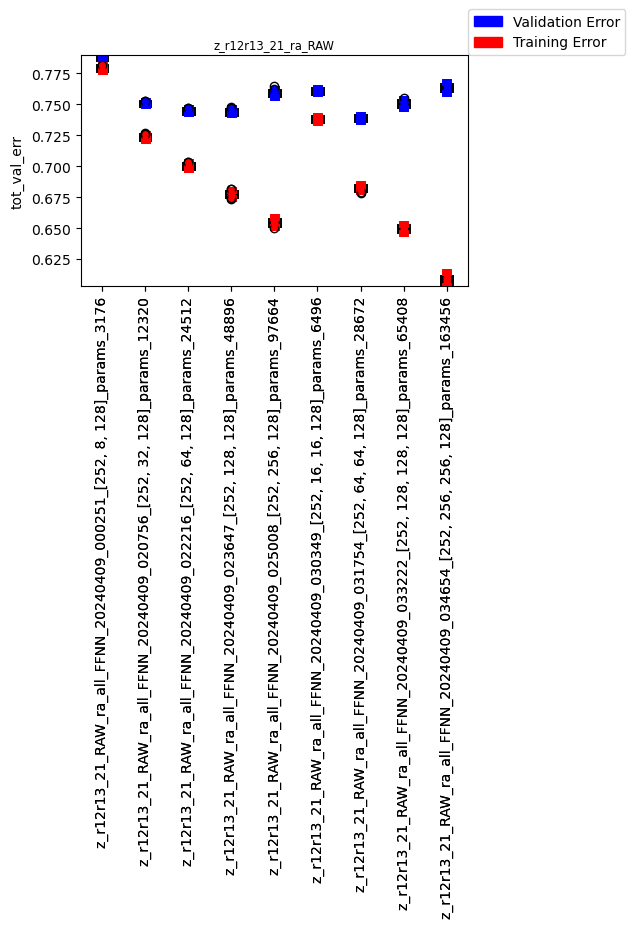

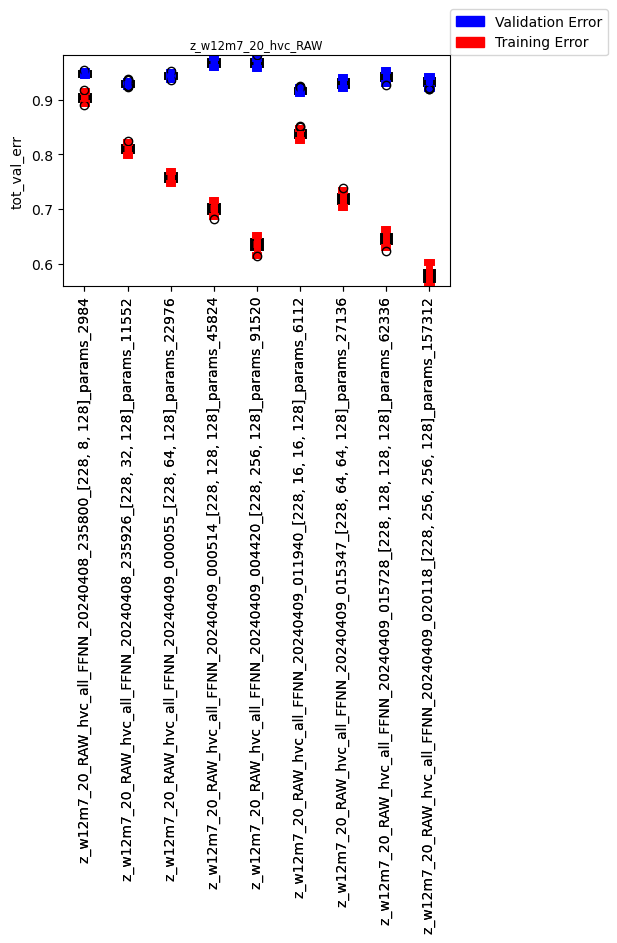

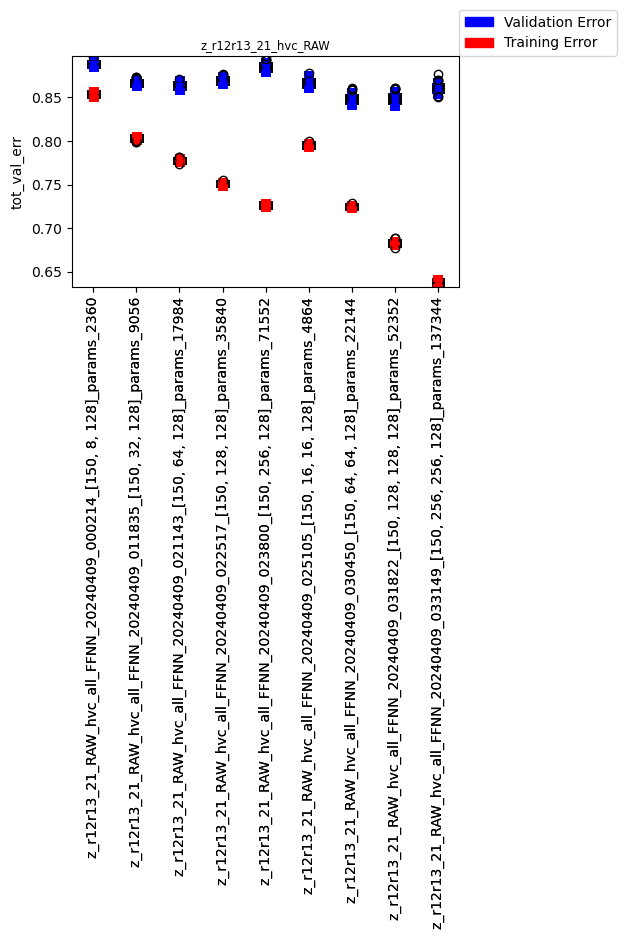

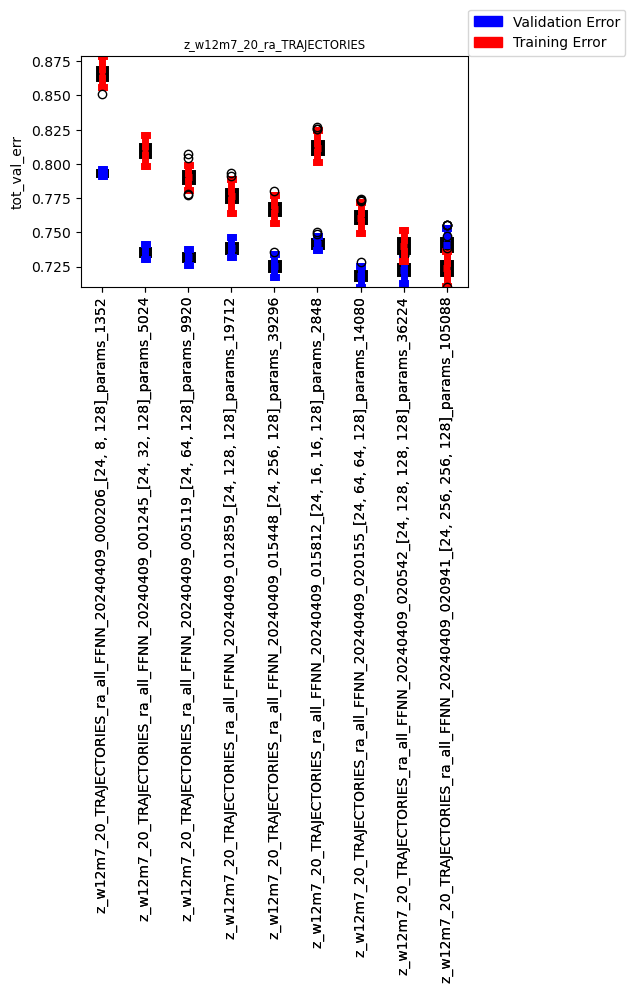

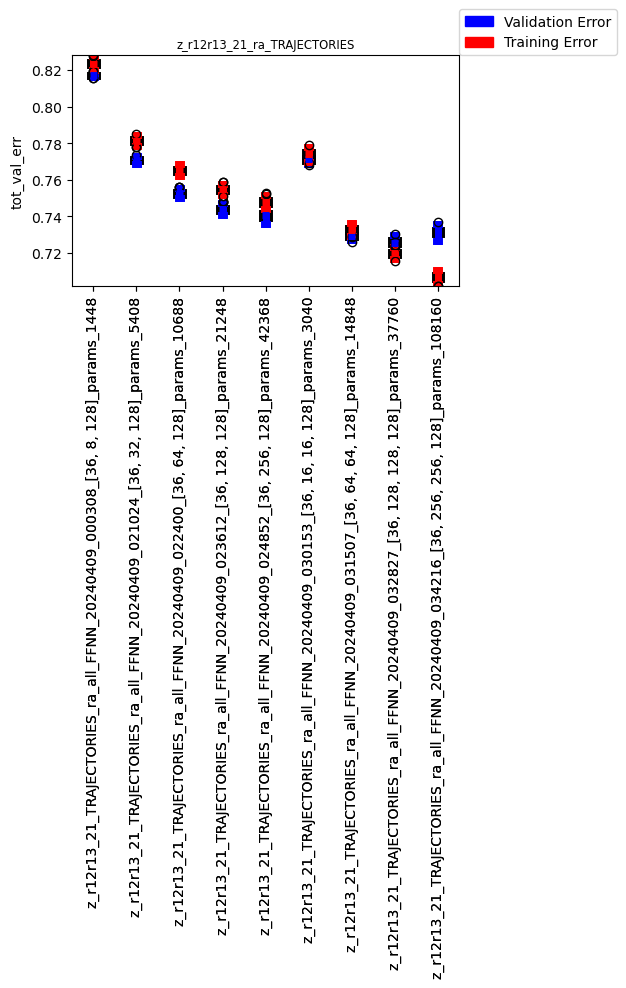

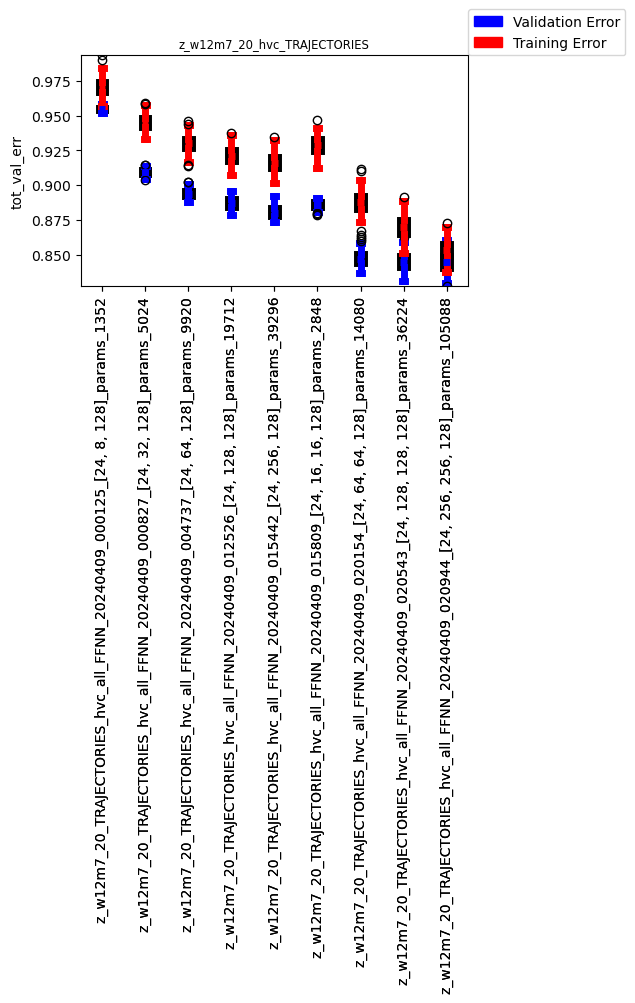

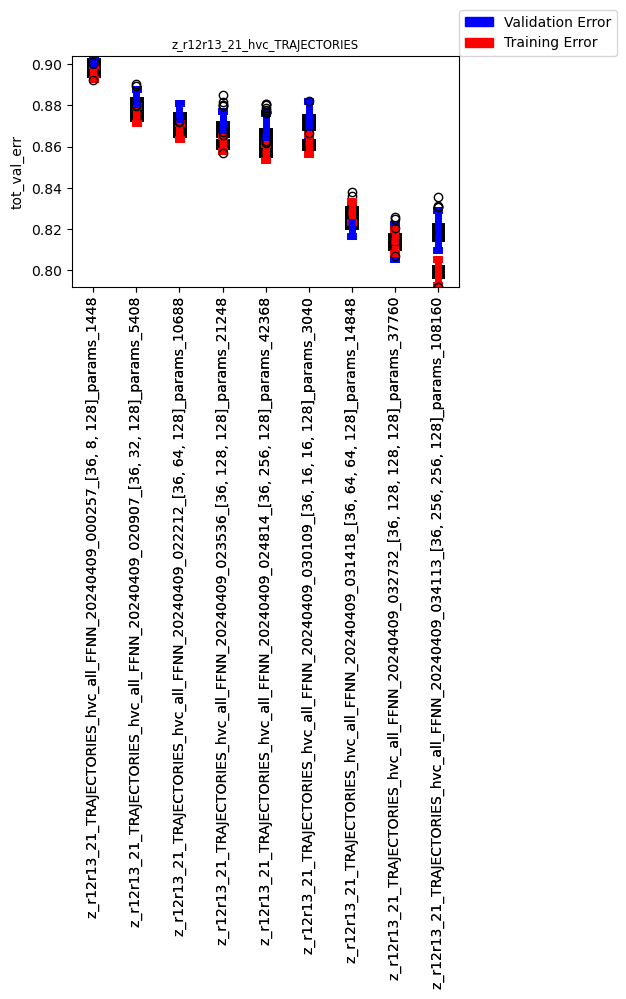

In [5]:
for k, project in projects.items():

    fig, axs = plt.subplots(figsize=(5, 3))
    positions = 1
    x_labels = []
    for loc, m in enumerate(df_models['experiment_name']):
        if all(s in m for s in project):
            
            color, linewidth = 'blue', 5
            axs.boxplot(df_models.loc[loc]['tot_val_err'][-200:], positions=[positions],
                              patch_artist=True, boxprops=dict(facecolor=color, linewidth=linewidth),
                              whiskerprops=dict(color=color, linewidth=linewidth),
                              capprops=dict(color=color, linewidth=linewidth),
                              medianprops=dict(color=color, linewidth=linewidth))
    
            color, linewidth = 'red', 5
            axs.boxplot(df_models.loc[loc]['tot_train_err'][-200:], positions=[positions],
                              patch_artist=True, boxprops=dict(facecolor=color, linewidth=linewidth),
                              whiskerprops=dict(color=color, linewidth=linewidth),
                              capprops=dict(color=color, linewidth=linewidth),
                              medianprops=dict(color=color, linewidth=linewidth))
            positions += 1
            x_labels.append('_'.join([df_models.loc[loc]['experiment_name'], df_models.loc[loc]['layers'], 'params', str(df_models.loc[loc]['total_params'])]))
            x_labels.append('_'.join([df_models.loc[loc]['experiment_name'], df_models.loc[loc]['layers'], 'params', str(df_models.loc[loc]['total_params'])]))
    
    axs.set_xticklabels(x_labels, rotation=90)
    axs.set_ylabel('tot_val_err')
    axs.set_title('_'.join(project))

    # Create custom legend handles
    blue_patch = mpatches.Patch(color='blue', label='Validation Error')
    red_patch = mpatches.Patch(color='red', label='Training Error')
    axs.legend(handles=[blue_patch, red_patch], loc=[1,1])
    plt.show()


In [6]:
# Load models CSV info file
info_path = os.path.join(models_checkpoints_dir, 'models_info.csv')

# Check if the file exists and 
if os.path.isfile(info_path):
    df_models = pd.read_csv(info_path)

df_models['tot_val_err'] = df_models['tot_val_err'].apply(ast.literal_eval)
df_models['tot_train_err'] = df_models['tot_train_err'].apply(ast.literal_eval)

In [7]:
df_models.columns #,df_models['config_id']

Index(['dataset_dir', 'models_checkpoints_dir', 'train_figures_dir',
       'dataset_filename', 'neural_mode', 'nucleus', 'neural_key', 'network',
       'bird', 'date', 'session', 'config_id', 'neural_history_ms',
       'gaussian_smoothing_sigma', 'max_temporal_shift_ms', 'noise_level',
       'transform_probability', 'percent_train', 'percent_test', 'batch_size',
       'learning_rate', 'num_epochs', 'hidden_layer_sizes', 'dropout_prob',
       'experiment_name', 'layers', 'total_params', 'train_idxs', 'test_idxs',
       'tot_train_loss', 'tot_train_err', 'tot_val_loss', 'tot_val_err'],
      dtype='object')

In [27]:
b1ra-raw  = 015856
b2ra-raw  = 031754
b1hvc-raw = 015347
b2hvc-raw = 030450

b1ra-trj  = 020155
b2ra-trj  = 031507
b1hvc-trj = 020154
b2hvc-trj = 031418

SyntaxError: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (1477921965.py, line 1)

spiketrains HVC


FileNotFoundError: [Errno 2] No such file or directory: '/home/jovyan/pablo_tostado/bird_song/enSongDec/models_checkpoints/'

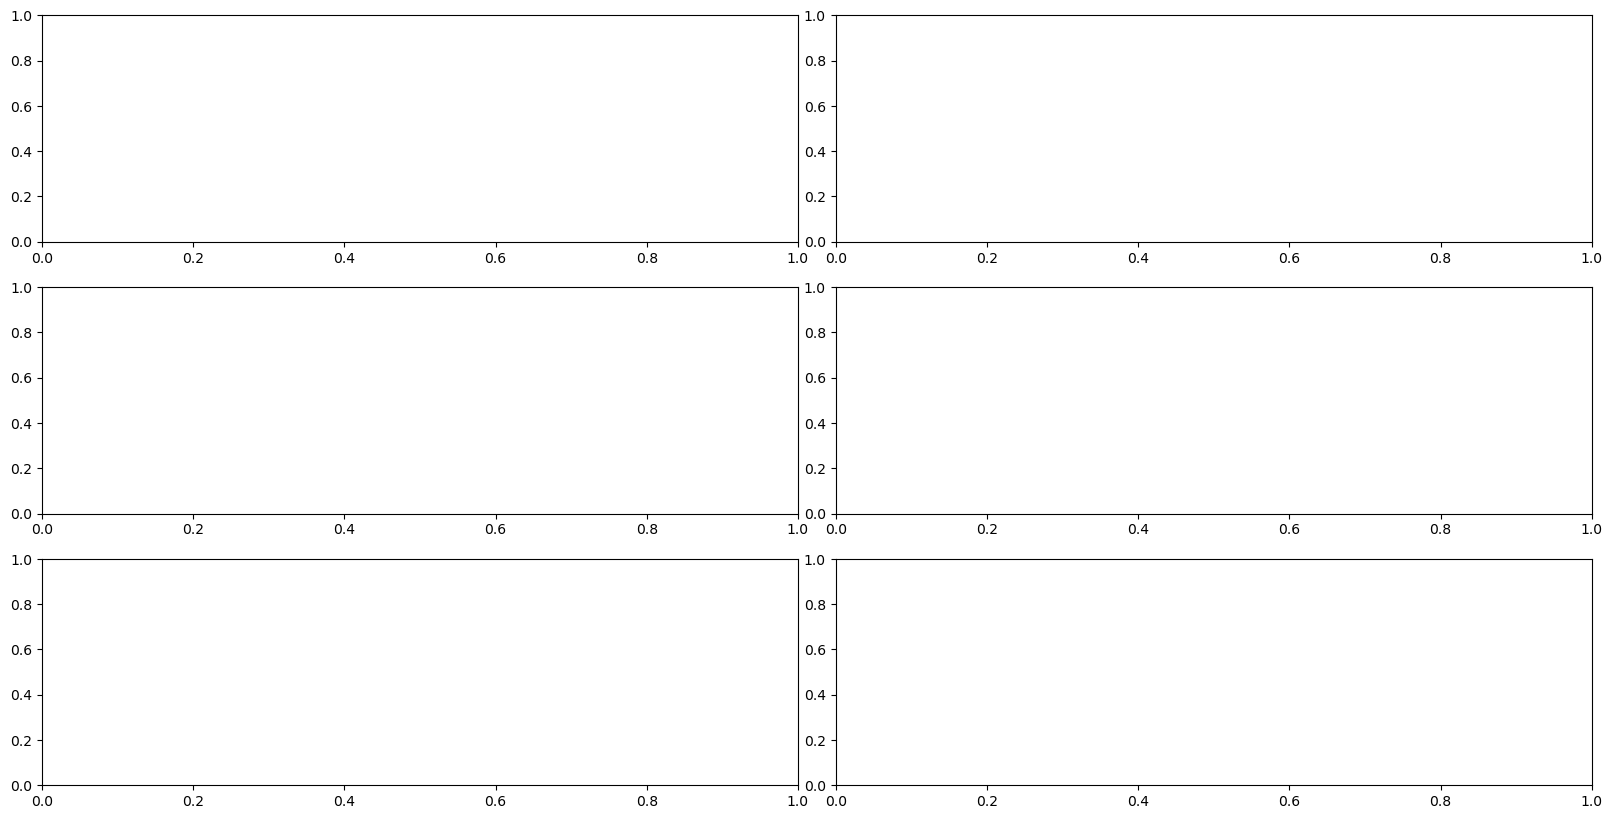

In [37]:
warnings.filterwarnings("ignore")

bird = 'z_w12m7_20'
models_dict = {
    'spiketrains': {
        'HVC': '015347',
        'RA': '015856'
    },
    
    'latent-trajectories': {
        'HVC': '020154',
        'RA': '020155'
    }
}

models_checkpoints_dir = '/home/jovyan/pablo_tostado/bird_song/enSongDec/models_checkpoints/'
column_names = ['model_name', 'nucleus', 'model', 'Spectrogram reconstruction error']
decoding_accuracy_df1 = pd.DataFrame(columns=column_names)

# Plotting setup
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 10))
plt.subplots_adjust(wspace=0.05)

# Processing each model type and nucleus
for col, model_type in enumerate(models_dict):
    for row, nucleus in enumerate(models_dict[model_type]):
        print(model_type, nucleus)

        # Load model
        model_timestamp = models_dict[model_type][nucleus]
        model_extension = '.pt'  
        model_files = [file for file in os.listdir(models_checkpoints_dir) if file.endswith(model_extension)]
        model_filename = next((file for file in model_files if model_timestamp in file), None)

        print('Loading model: ', model_filename)
        ffnn_model, test_dataset, test_loader, fs_audio, encodec_model, scales = load_model_statedict(models_checkpoints_dir, model_filename)

        # Reconstruct spectrogram
        scale = torch.mean(scales)
        original_audio, decoded_audio = get_original_reconstructed_audio(ffnn_model, test_dataset, test_loader, fs_audio, encodec_model, scale)

        # Calculate spectrogram reconstruction error
        s1 = su.normalize_signal(au.pretty_spectrogram(original_audio))
        s2 = su.normalize_signal(au.pretty_spectrogram(decoded_audio))
        spec_reconstruction_error = mean_squared_error(s1, s2, multioutput='raw_values')
        
        decoding_accuracy_df1.loc[len(decoding_accuracy_df1)] = [model_filename, nucleus, model_type, spec_reconstruction_error]

        # Plot original and reconstructed
        plot_s = 1
        plot_samples = int(plot_s*fs_audio)
        
        plt.subplots(nrows=1, figsize=(10, 3))
        plt.title(model_type + nucleus)
        plt.plot(original_audio[:plot_samples])
        plt.plot(decoded_audio[:plot_samples])
        
        xlabel = True if row == 1 else False
        # ylabel = True if col == 0 else False
        # plot_spectrogram(original_audio, fs_audio, plot_samples, ax=axes[row+1, col], xlabel=xlabel)
        plot_spectrogram(decoded_audio, fs_audio, plot_samples, ax=axes[row+1, col], xlabel=xlabel)

# Top row: repeat the plot of the original spectrograms in both columns
plot_spectrogram(original_audio, fs_audio, plot_samples, ax=axes[0, 0], xlabel=False, ylabel=True)
plot_spectrogram(original_audio, fs_audio, plot_samples, ax=axes[0, 1], xlabel=False, ylabel=False)
axes[1,1].set_ylabel(''), axes[1,1].set_yticks([])
axes[2,1].set_ylabel(''), axes[2,1].set_yticks([])



'latent-trajectories'

,model_name,nucleus,model,Spectrogram reconstruction error
2,z_w12m7_20_TRAJECTORIES_hvc_all_FFNN_20240409_...,HVC,latent-trajectories,"[0.01760916910750231, 0.00861737539137792, 0.0..."
3,z_w12m7_20_TRAJECTORIES_ra_all_FFNN_20240409_0...,RA,latent-trajectories,"[0.013125712871888259, 0.009047499453901658, 0..."


'spiketrains'

,model_name,nucleus,model,Spectrogram reconstruction error
0,z_w12m7_20_RAW_hvc_all_FFNN_20240409_015347.pt,HVC,spiketrains,"[0.022128682775616814, 0.015305187636322408, 0..."
1,z_w12m7_20_RAW_ra_all_FFNN_20240409_015856.pt,RA,spiketrains,"[0.01418434690911002, 0.006074881578863378, 0...."


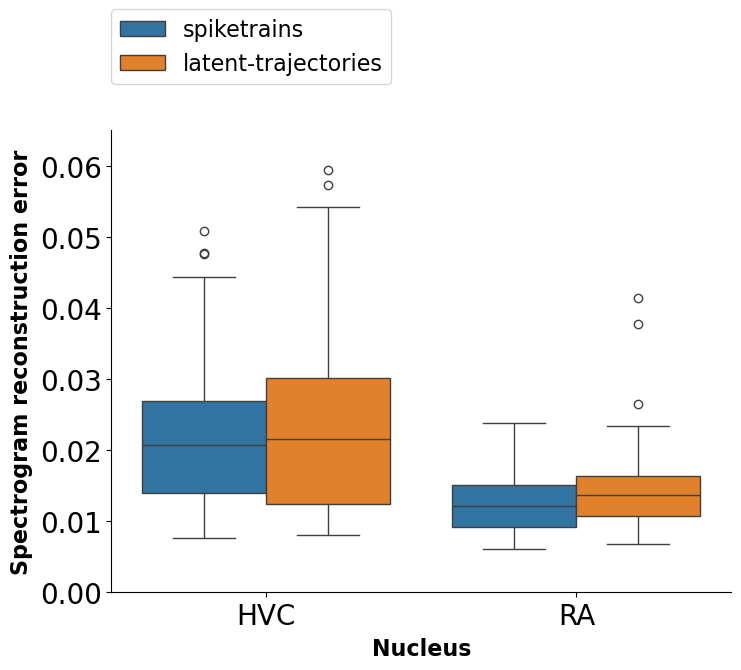

In [35]:
# Calculate statistical significance using t-test
significance = {}
for nucleus, group in decoding_accuracy_df1.groupby('model'):
    display(nucleus, group)
    hvc_error = group[group['nucleus'] == 'HVC']['Spectrogram reconstruction error'].values[0]
    ra_error = group[group['nucleus'] == 'RA']['Spectrogram reconstruction error'].values[0]
    _, p_value = stats.ttest_ind(hvc_error, ra_error)
    significance[nucleus] = p_value


# Create separate rows for each value in the 'error' list
error_type = 'Spectrogram reconstruction error'
df_expanded = decoding_accuracy_df1.explode(error_type)
df_expanded[error_type] = pd.to_numeric(df_expanded[error_type])

# Create a box and whisker plot
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='nucleus', y=error_type, hue='model', data=df_expanded, notch=False)

# # Add significance bars
# for i, p_value in enumerate(significance.values()):
#     if p_value < 0.05:  # Adjust significance threshold as needed
#         ax.plot([i - 0.2, i + 0.2], [0.062, 0.062], lw=1.5, c='black')  # Adjust y-coordinate and appearance as needed

# # Add asterisks for statistical significance
# for i, p_value in enumerate(significance.values()):
#     if p_value < 0.05:  # Adjust significance threshold as needed
#         plt.text(i, 0.0625, "***", ha='center', va='bottom', fontsize=16)  # Adjust position and appearance as needed

plt.xlabel('Nucleus', fontsize=16, fontweight='bold')
plt.ylabel(error_type, fontsize=16, fontweight='bold')

# Remove top and right spines
ax.set_ylim([0, 0.065])
ax.set_xlim([-0.5, len(significance) - 0.5])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=20)  # Adjust 'labelsize' as needed
plt.legend(fontsize='16', loc=(0,1.1)) 

plt.show()


In [ ]:
b1ra-raw  = 015856
b2ra-raw  = 031754
b1hvc-raw = 015347
b2hvc-raw = 030450

b1ra-trj  = 020155
b2ra-trj  = 031507
b1hvc-trj = 020154
b2hvc-trj = 031418

spiketrains HVC
Loading model:  z_r12r13_21_RAW_hvc_all_FFNN_20240409_030450.pt
z_r12r13_21_RAW_hvc_all_FFNN_20240409_030450_metadata.json
train_idxs:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]  - test_ixs:  [37, 38, 39, 40, 41, 42, 43, 44, 45, 46]  - model_layers:  [150, 64, 64, 128]
Length of neural trials: 899.9666666666667 ms, length of audio trials: 899.96 ms. 
Pre-processing neural data as RAW
Using 3 bins of neural data history.
Train samples:  4810
Test samples:  1320
spiketrains RA
Loading model:  z_r12r13_21_RAW_ra_all_FFNN_20240409_031754.pt
z_r12r13_21_RAW_ra_all_FFNN_20240409_031754_metadata.json
train_idxs:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]  - test_ixs:  [37, 38, 39, 40, 41, 42, 43, 44, 45, 46]  - model_layers:  [252, 64, 64, 128]
Length of neural trials: 899.9666666666667

(Text(0, 0.5, ''), [])

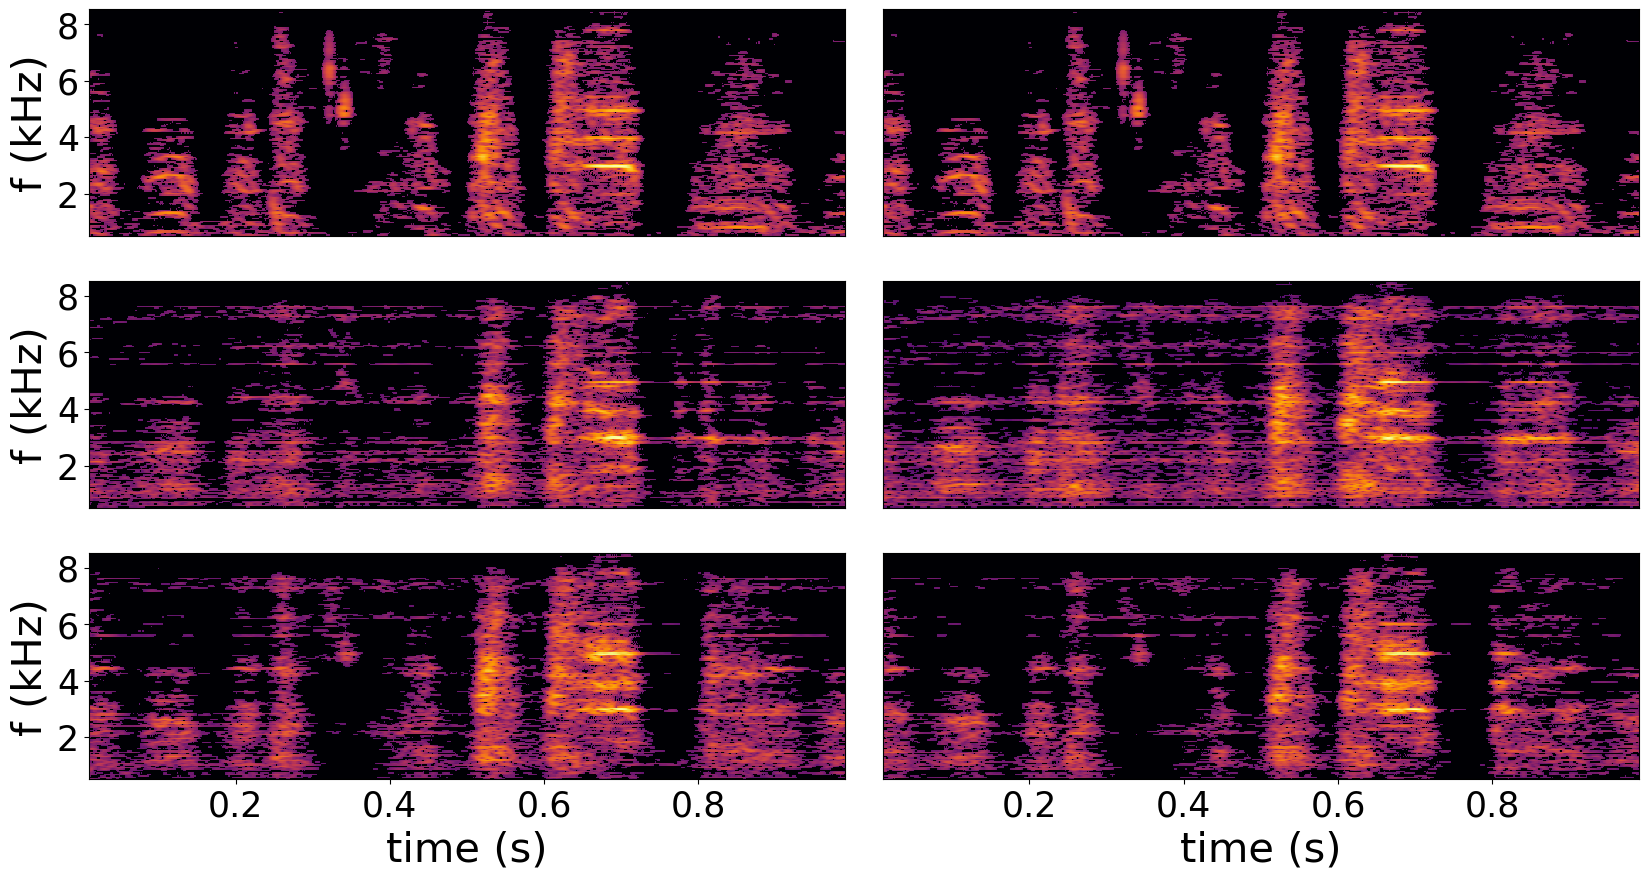

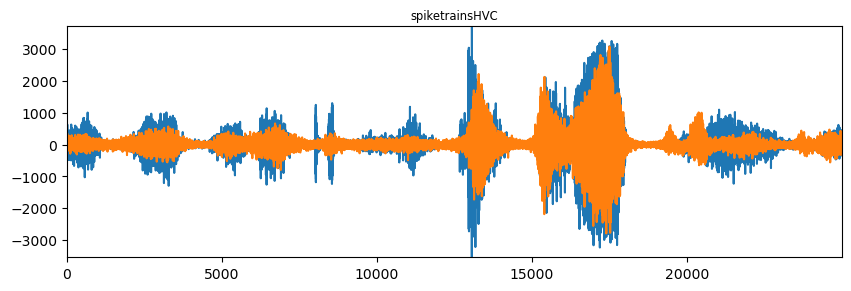

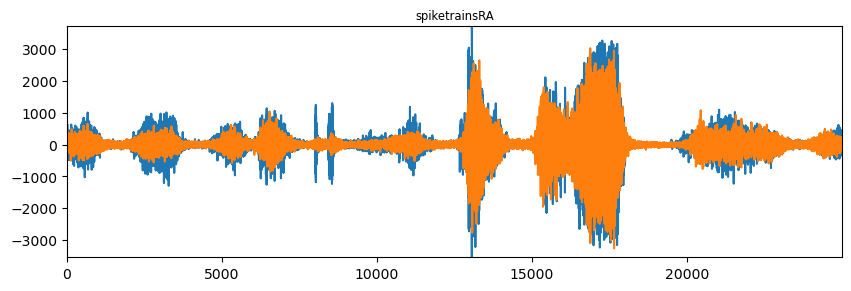

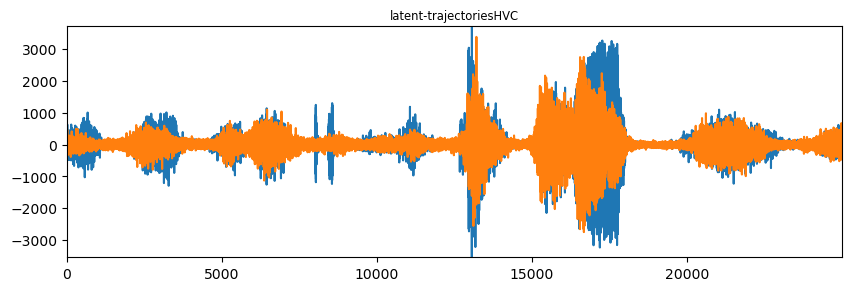

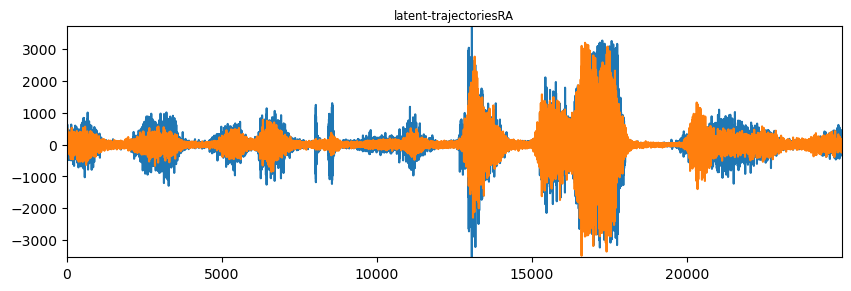

In [29]:
warnings.filterwarnings("ignore")

bird = 'z_r12r13_21'
models_dict = {
    'spiketrains': {
        'HVC': '030450',
        'RA': '031754'
    },
    
    'latent-trajectories': {
        'HVC': '031418',
        'RA': '031507'
    }
}


models_checkpoints_dir = '/home/jovyan/pablo_tostado/bird_song/enSongDec/models_checkpoints/'
column_names = ['model_name', 'nucleus', 'model', 'Spectrogram reconstruction error']
decoding_accuracy_df2 = pd.DataFrame(columns=column_names)

# Plotting setup
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 10))
plt.subplots_adjust(wspace=0.05)

# Processing each model type and nucleus
for col, model_type in enumerate(models_dict):
    for row, nucleus in enumerate(models_dict[model_type]):
        print(model_type, nucleus)

        # Load model
        model_timestamp = models_dict[model_type][nucleus]
        model_extension = '.pt'  
        model_files = [file for file in os.listdir(models_checkpoints_dir) if file.endswith(model_extension)]
        model_filename = next((file for file in model_files if model_timestamp in file), None)

        print('Loading model: ', model_filename)
        ffnn_model, test_dataset, test_loader, fs_audio, encodec_model, scales = load_model_statedict(models_checkpoints_dir, model_filename)

        # Reconstruct spectrogram
        scale = torch.mean(scales)
        original_audio, decoded_audio = get_original_reconstructed_audio(ffnn_model, test_dataset, test_loader, fs_audio, encodec_model, scale)

        # Calculate spectrogram reconstruction error
        s1 = su.normalize_signal(au.pretty_spectrogram(original_audio))
        s2 = su.normalize_signal(au.pretty_spectrogram(decoded_audio))
        spec_reconstruction_error = mean_squared_error(s1, s2, multioutput='raw_values')
        
        decoding_accuracy_df2.loc[len(decoding_accuracy_df2)] = [model_filename, nucleus, model_type, spec_reconstruction_error]

        plt.subplots(nrows=1, figsize=(10, 3))
        plt.title(model_type + nucleus)
        plt.plot(original_audio[:plot_samples])
        plt.plot(decoded_audio[:plot_samples])
        
        # Plot original and reconstructed
        plot_ms = 1
        plot_samples = int(plot_ms*fs_audio)
        
        xlabel = True if row == 1 else False
        # ylabel = True if col == 0 else False
        # plot_spectrogram(original_audio, fs_audio, plot_samples, ax=axes[row+1, col], xlabel=xlabel)
        plot_spectrogram(decoded_audio, fs_audio, plot_samples, ax=axes[row+1, col], xlabel=xlabel)

# Top row: repeat the plot of the original spectrograms in both columns
plot_spectrogram(original_audio, fs_audio, plot_samples, ax=axes[0, 0], xlabel=False, ylabel=True)
plot_spectrogram(original_audio, fs_audio, plot_samples, ax=axes[0, 1], xlabel=False, ylabel=False)
axes[1,1].set_ylabel(''), axes[1,1].set_yticks([])
axes[2,1].set_ylabel(''), axes[2,1].set_yticks([])


'latent-trajectories'

,model_name,nucleus,model,Spectrogram reconstruction error
2,z_r12r13_21_TRAJECTORIES_hvc_all_FFNN_20240409...,HVC,latent-trajectories,"[0.03041043316680999, 0.01753391188344881, 0.0..."
3,z_r12r13_21_TRAJECTORIES_ra_all_FFNN_20240409_...,RA,latent-trajectories,"[0.025731580454800205, 0.012215674263250096, 0..."


'spiketrains'

,model_name,nucleus,model,Spectrogram reconstruction error
0,z_r12r13_21_RAW_hvc_all_FFNN_20240409_030450.pt,HVC,spiketrains,"[0.02626778507321643, 0.017778199790317365, 0...."
1,z_r12r13_21_RAW_ra_all_FFNN_20240409_031754.pt,RA,spiketrains,"[0.020961278085671067, 0.009517249360416119, 0..."


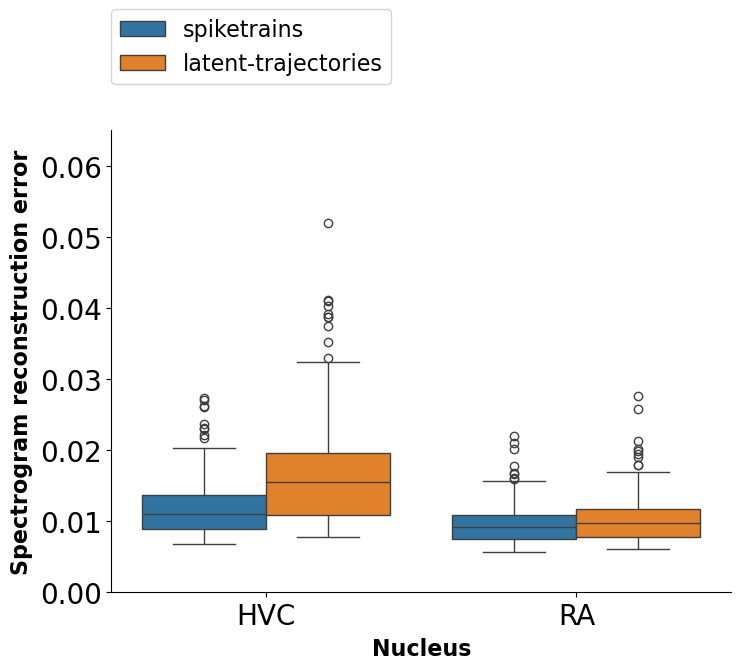

In [32]:
# Calculate statistical significance using t-test
significance = {}
for nucleus, group in decoding_accuracy_df2.groupby('model'):
    display(nucleus, group)
    hvc_error = group[group['nucleus'] == 'HVC']['Spectrogram reconstruction error'].values[0]
    ra_error = group[group['nucleus'] == 'RA']['Spectrogram reconstruction error'].values[0]
    _, p_value = stats.ttest_ind(hvc_error, ra_error)
    significance[nucleus] = p_value


# Create separate rows for each value in the 'error' list
error_type = 'Spectrogram reconstruction error'
df_expanded = decoding_accuracy_df2.explode(error_type)
df_expanded[error_type] = pd.to_numeric(df_expanded[error_type])

# Create a box and whisker plot
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='nucleus', y=error_type, hue='model', data=df_expanded, notch=False)

# # Add significance bars
# for i, p_value in enumerate(significance.values()):
#     if p_value < 0.05:  # Adjust significance threshold as needed
#         ax.plot([i - 0.2, i + 0.2], [0.062, 0.062], lw=1.5, c='black')  # Adjust y-coordinate and appearance as needed

# # Add asterisks for statistical significance
# for i, p_value in enumerate(significance.values()):
#     if p_value < 0.05:  # Adjust significance threshold as needed
#         plt.text(i, 0.0625, "***", ha='center', va='bottom', fontsize=16)  # Adjust position and appearance as needed

plt.xlabel('Nucleus', fontsize=16, fontweight='bold')
plt.ylabel(error_type, fontsize=16, fontweight='bold')

# Remove top and right spines
ax.set_ylim([0, 0.065])
ax.set_xlim([-0.5, len(significance) - 0.5])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=20)  # Adjust 'labelsize' as needed
plt.legend(fontsize='16', loc=(0,1.1)) 

plt.show()


In [26]:
s1.shape, s1, s2.shape, s2

((3432, 256),
 array([[0.55693297, 0.51009756, 0.37362164, ..., 0.18228503, 0.12323743,
         0.18588714],
        [0.51412773, 0.35537294, 0.50300394, ..., 0.1097423 , 0.14339424,
         0.12428025],
        [0.51059673, 0.44356937, 0.48973618, ..., 0.09107181, 0.17309235,
         0.15456803],
        ...,
        [0.47542721, 0.43030203, 0.33893517, ..., 0.02582257, 0.06808247,
         0.07425608],
        [0.49562594, 0.4089771 , 0.36453413, ..., 0.06592466, 0.09163257,
         0.03586808],
        [0.50346873, 0.43085885, 0.39727223, ..., 0.18701935, 0.1963434 ,
         0.1866084 ]]),
 (3432, 256),
 array([[0.60985556, 0.58069087, 0.50358408, ..., 0.23899374, 0.22715809,
         0.23906142],
        [0.60872374, 0.56183678, 0.48542055, ..., 0.18653077, 0.09975903,
         0.18302838],
        [0.59618859, 0.52549681, 0.34973348, ..., 0.16530045, 0.15295814,
         0.1709602 ],
        ...,
        [0.57365004, 0.49022691, 0.45938309, ..., 0.15464801, 0.16215684,
      